In [1]:
import matplotlib.pyplot as plt
import numpy as np
import operator
import scipy.optimize
import torch

import timeit
import tracemalloc

from functools import *
from typing import *

## Helper functions

In [2]:
def compose(f: Callable, g: Callable):
    return lambda x: f(g(x))


def rosenbrock(x: np.array) -> float:
    a, b = 2, 5
    return (a - x[0]) ** 2 + b * (x[1] - x[0] ** 2) ** 2


def torch_grad(f):
    def impl(x):
        x = torch.tensor(x, requires_grad=True)
        y = f(x)
        y.backward()
        return x.grad

    return impl


def perf(f, n=100):
    print(f"Avg time: {timeit.timeit(f, number=n) / n * 1000} ms")
    sum_mem = (0, 0)
    for _ in range(n):
        tracemalloc.start()
        f()
        sum_mem = map(operator.add, sum_mem, tracemalloc.get_traced_memory())
        tracemalloc.stop()
    cur, peak = map(lambda m: f"{m / n / 1024} KB", sum_mem)
    print(f"Avg memory (cur, peak): {cur}, {peak}")
    return f()

### `scipy.optimize.minimize`

In [3]:
print(scipy.optimize.minimize(rosenbrock, np.zeros(2)))

      fun: 6.917139163925168e-13
 hess_inv: array([[0.50860031, 2.03755989],
       [2.03755989, 8.26400669]])
      jac: array([ 9.30183538e-07, -2.70347420e-07])
  message: 'Optimization terminated successfully.'
     nfev: 63
      nit: 15
     njev: 21
   status: 0
  success: True
        x: array([1.99999917, 3.99999665])


In [4]:
print(scipy.optimize.least_squares(rosenbrock, np.zeros(2), max_nfev=4000))

 active_mask: array([0., 0.])
        cost: 2.6482841383049063e-11
         fun: array([7.27775259e-06])
        grad: array([-5.69898890e-09, -8.35210555e-09])
         jac: array([[-0.00078307, -0.00114762]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 3422
        njev: 3388
  optimality: 8.352105548001764e-09
      status: 1
     success: True
           x: array([1.99731451, 3.98915045])


## 3a

In [5]:
print(scipy.optimize.minimize(rosenbrock, np.zeros(2), jac=torch_grad(rosenbrock)))

      fun: 9.371329794568943e-15
 hess_inv: array([[0.50860079, 2.0375629 ],
       [2.0375629 , 8.26402317]])
      jac: array([ 9.30300925e-07, -2.70377765e-07])
  message: 'Optimization terminated successfully.'
     nfev: 21
      nit: 15
     njev: 21
   status: 0
  success: True
        x: array([1.99999992, 3.99999967])


In [6]:
print(scipy.optimize.least_squares(rosenbrock, np.zeros(2), jac=torch_grad(rosenbrock), max_nfev=4000))

 active_mask: array([0., 0.])
        cost: 2.6405243776878244e-11
         fun: array([7.26708247e-06])
        grad: array([-6.38766165e-09, -8.16652537e-09])
         jac: array([[-0.00087899, -0.00112377]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 3422
        njev: 3388
  optimality: 8.166525367069686e-09
      status: 1
     success: True
           x: array([1.99731598, 3.98915876])


## 3b

### From lab 3

In [7]:
def calc_pseudoinverse(x):
    return np.linalg.pinv(x.T.dot(x)).dot(x.T)


def calc_pseudoinverse_powell(x):
    return x.T.dot(x).dot(x.T) if np.linalg.det(x.T.dot(x)) == 0 else calc_pseudoinverse(x)


def calc_residual(f, x, y, coef):
    return f(coef, x) - y


def calculate_jacobian(f, x, y, x0, step):
    jacobian, y0 = [], calc_residual(f, x, y, x0)
    for i in range(len(x0)):
        new_x = x0.copy()
        new_x[i] += step
        jacobian.append((calc_residual(f, x, y, new_x) - y0) / step)
    return np.array(jacobian).T


def gradient_descent_3(pseudoinverse_f, f, x, y, start_point, max_iter_num, stop_difference=1e-10):
    coef, rmse_prev = start_point, np.inf
    differences = [sum(calc_residual(f, x, y, coef) ** 2)]
    for i in range(max_iter_num):
        residual, jacobian = calc_residual(f, x, y, coef), calculate_jacobian(f, x, y, coef, 1e-7)
        coef -= pseudoinverse_f(jacobian).dot(residual)
        differences.append(sum(calc_residual(f, x, y, coef) ** 2))
        rmse = np.sqrt(sum(residual ** 2))
        if np.abs(rmse_prev - rmse) < stop_difference:
            break
        rmse_prev = rmse
    # print(i + 1)
    return coef, differences


call_gauss_newton = partial(gradient_descent_3, calc_pseudoinverse)
call_powell = partial(gradient_descent_3, calc_pseudoinverse_powell)

In [8]:
def call_least_squares(f, x, y, start_point):
    return scipy.optimize.least_squares(f, start_point, args=(x, y))

In [9]:
def f(coef, x):
    return coef[0] + coef[1] * x[:, 0] + coef[2] * x[:, 0] ** 2 + coef[3] * x[:, 0] ** 3 + coef[4] * np.sin(x[:, 0])


def f2(coef, x, y):
    return coef[0] + coef[1] * x + coef[2] * x ** 2 + coef[3] * x ** 3 + coef[4] * np.sin(x) - y


coef = [1, 0.1, 0.1, -1e-3, 10]
x1 = np.linspace(-10, 40, 50)
x2 = np.column_stack(np.meshgrid(x1))
y2 = f(coef, x2) + np.random.normal(-10, 10, size=len(x2))

Avg time: 0.8032912999624386 ms
Avg memory (cur, peak): 0.224580078125 KB, 8.969912109375 KB
[-1.09356388e+01  4.65460737e-01  8.99530851e-02 -9.01745964e-04
  9.24529691e+00] [95774.14641053969, 5683.160199924749, 5683.160199924747, 5683.160199924745]


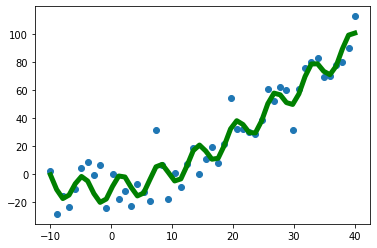

In [10]:
new_coef, differences = perf(lambda: call_gauss_newton(f, x2, y2, np.zeros(5), 100))
print(new_coef, differences)
plt.plot(x1, y2, 'o')
plt.plot(x2, f(new_coef, x2), color="g", linewidth=5)
plt.show()

Avg time: 0.8540515499771573 ms
Avg memory (cur, peak): 0.219482421875 KB, 8.984384765625 KB
[-1.09356388e+01  4.65460737e-01  8.99530851e-02 -9.01745964e-04
  9.24529691e+00] [95774.14641053969, 5683.160199924749, 5683.160199924747, 5683.160199924745]


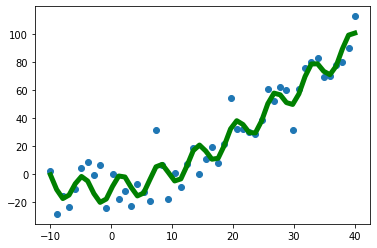

In [11]:
new_coef, differences = perf(lambda: call_powell(f, x2, y2, np.zeros(5), 100))
print(new_coef, differences)
plt.plot(x1, y2, 'o')
plt.plot(x2, f(new_coef, x2), color="g", linewidth=5)
plt.show()

Avg time: 2.697163900011219 ms
Avg memory (cur, peak): 0.228388671875 KB, 22.041865234375 KB
[-1.09356385e+01  4.65460756e-01  8.99530825e-02 -9.01745914e-04
  9.24529699e+00]


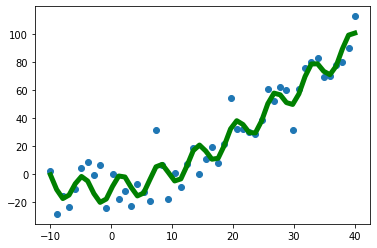

In [12]:
res_lsq = perf(lambda: call_least_squares(f2, x1, y2, np.zeros(5)))
print(res_lsq.x)
plt.plot(x1, y2, 'o')
plt.plot(x1, f2(res_lsq.x, x1, 0), color="g", linewidth=5)
plt.show()

## 3c

In [13]:
def booth(x):
    return (x[0] + 2 * x[1] - 7) ** 2 + (2 * x[0] + x[1] - 5) ** 2


def draw(*bounds):
    print("Bounds: ", *bounds)
    print(scipy.optimize.minimize(booth, np.zeros(2), bounds=[*bounds]).x)
    print()


draw((-10, 10), (-10, 10))
draw((-5, 5), (-5, 5))
draw((0, 5), (0, 5))
draw((3, 5), (3, 5))
draw((-10, -1), (-10, -1))
draw((1, 5), (0, 2))

Bounds:  (-10, 10) (-10, 10)
[0.99999891 3.00000103]

Bounds:  (-5, 5) (-5, 5)
[1.0000015  2.99999851]

Bounds:  (0, 5) (0, 5)
[1.0000015  2.99999851]

Bounds:  (3, 5) (3, 5)
[3. 3.]

Bounds:  (-10, -1) (-10, -1)
[-1. -1.]

Bounds:  (1, 5) (0, 2)
[1.80000004 2.        ]

